In [2]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
import itertools


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from datetime import datetime as dt
import datetime

In [3]:
# read data file
FlightData1 = pd.read_csv('data/FlightData_2016_2017.csv')
FlightData2 = pd.read_csv('data/FlightData_2017_2018.csv')

In [4]:
FlightData1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288138 entries, 0 to 288137
Data columns (total 21 columns):
Unnamed: 0             288138 non-null int64
FL_DATE                288138 non-null object
YEAR                   288138 non-null int64
MONTH                  288138 non-null int64
DAY_OF_MONTH           288138 non-null int64
DAY_OF_WEEK            288138 non-null int64
OP_UNIQUE_CARRIER      288138 non-null object
OP_CARRIER_FL_NUM      288138 non-null int64
ORIGIN                 288138 non-null object
DEST                   288138 non-null object
CRS_ARR_TIME           288138 non-null int64
ARR_TIME               288138 non-null float64
DISTANCE               288138 non-null float64
CANCELLED              288138 non-null float64
CARRIER_DELAY          51344 non-null float64
WEATHER_DELAY          51344 non-null float64
NAS_DELAY              51344 non-null float64
SECURITY_DELAY         51344 non-null float64
LATE_AIRCRAFT_DELAY    51344 non-null float64
Delay              

In [5]:
def SetUp_Xy(FlightData):
    #print(FlightData.shape)
    # drop Alaska Airlines flights to shrink dataset
    #FlightData.drop(FlightData[FlightData.OP_UNIQUE_CARRIER == 'AS'].index,inplace=True)
    #print(FlightData.shape)
    
    # take a smaller sample of the data
    #FlightData = FlightData.sample(n=1000)

    SEA_outbound = False  # drop outbound flights if True
    SEA_inbound = True    # drop inbound flights if True
    if not SEA_inbound:
        print('dropping records arriving in SEA')
        FlightData.drop(FlightData[FlightData.DEST == 'SEA'].index,inplace=True)

    elif not SEA_outbound:
        print('dropping flights departing SEA')
        FlightData.drop(FlightData[FlightData.ORIGIN == 'SEA'].index,inplace=True)
    #print(FlightData.shape)

    # create one-hot columns for Airline Carrier
    X = pd.get_dummies(FlightData[['OP_UNIQUE_CARRIER']])
    #X = pd.DataFrame()
    
    # add datetime for FL_DATE (flight date)
    #X['FlightDate'] = pd.to_datetime(FlightData['FL_DATE'])
    #X['FlightDate'] = pd.to_datetime(FlightData['FL_DATE']).apply(lambda x: x.toordinal())
    #X['Day_of_year'] = (pd.to_datetime(FlightData['FL_DATE'])).dt.dayofyear

    # add other columns 
    #X = pd.concat([X, FlightData[['MONTH','DAY_OF_WEEK','Day_of_year','CRS_ARR_TIME',
    #                              'ARR_TIME','DISTANCE']]], axis=1, sort=False)
    X = pd.concat([X, FlightData[['MONTH','DAY_OF_WEEK','CRS_ARR_TIME',
                                  'ARR_TIME','DISTANCE']]], axis=1, sort=False)
            
    # set up target
    y = FlightData['Delay']

    return X,y

In [6]:
X1,y1 = SetUp_Xy(FlightData1)
X2,y2 = SetUp_Xy(FlightData2)

dropping flights departing SEA
dropping flights departing SEA


In [ ]:
X1.columns

In [ ]:
X2.columns

In [7]:
# add G4 airline if not in database
if 'OP_UNIQUE_CARRIER_G4' not in X1.columns:
    print('adding OP_UNIQUE_CARRIER_G4 column')
    X1['OP_UNIQUE_CARRIER_G4'] = 0
    # re-order the columns to match X2
    X1 = X1[X2.columns]

adding OP_UNIQUE_CARRIER_G4 column


In [ ]:
X1.head()

In [ ]:
print(X.mean())

In [10]:
# create consistant normalization variables
DISTANCE_mean = X1.DISTANCE.mean()
DISTANCE_std  = X1.DISTANCE.std()
ARR_TIME_mean = X1.ARR_TIME.mean()
ARR_TIME_std  = X1.ARR_TIME.std()
CRS_ARR_TIME_mean = X1.CRS_ARR_TIME.mean()
CRS_ARR_TIME_std  = X1.CRS_ARR_TIME.std()
#Day_of_year_mean = X1.Day_of_year.mean()
#Day_of_year_std  = X1.Day_of_year.std()
DAY_OF_WEEK_std  = X1.DAY_OF_WEEK.std()
DAY_OF_WEEK_mean = X1.DAY_OF_WEEK.mean()
MONTH_mean = X1.MONTH.mean()
MONTH_std  = X1.MONTH.std()

In [11]:
X2.DISTANCE     = (X2.DISTANCE -     DISTANCE_mean)/DISTANCE_std
X2.ARR_TIME     = (X2.ARR_TIME -     ARR_TIME_mean)/ARR_TIME_std
X2.CRS_ARR_TIME = (X2.CRS_ARR_TIME - CRS_ARR_TIME_mean)/CRS_ARR_TIME_std
#X2.Day_of_year  = (X2.Day_of_year -  Day_of_year_mean)/Day_of_year_std
X2.DAY_OF_WEEK  = (X2.DAY_OF_WEEK -  DAY_OF_WEEK_mean)/DAY_OF_WEEK_std
X2.MONTH        = (X2.MONTH -        MONTH_mean)/MONTH_std

In [12]:
X1.DISTANCE     = (X1.DISTANCE -     DISTANCE_mean)/DISTANCE_std
X1.ARR_TIME     = (X1.ARR_TIME -     ARR_TIME_mean)/ARR_TIME_std
X1.CRS_ARR_TIME = (X1.CRS_ARR_TIME - CRS_ARR_TIME_mean)/CRS_ARR_TIME_std
#X1.Day_of_year  = (X1.Day_of_year -  Day_of_year_mean)/Day_of_year_std
X1.DAY_OF_WEEK  = (X1.DAY_OF_WEEK -  DAY_OF_WEEK_mean)/DAY_OF_WEEK_std
X1.MONTH        = (X1.MONTH -        MONTH_mean)/MONTH_std

### Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

# STEP 1: split X and y into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, random_state=42)

In [19]:
# create a dataset combining X2 and X1
X3_train = pd.concat([X2_train,X1_train])
y3_train = pd.concat([y2_train,y1_train])

# reduce training set by 50%
X3_train.sample(frac=0.5, replace=True, random_state=1)
y3_train.sample(frac=0.5, replace=True, random_state=1)

282246    0
196393    0
11807     1
251065    0
3375      0
133885    0
175577    0
207307    0
49691     0
10852     0
267191    0
63180     0
107145    0
139778    0
239537    0
206836    1
156522    0
92080     0
162108    0
188536    0
237125    0
41741     1
167366    0
272228    1
194088    0
4224      0
93137     0
9165      0
223388    0
207866    0
         ..
22073     0
158236    0
159257    0
129846    0
200937    0
218807    0
280793    0
103867    0
253238    0
198473    0
263173    0
36867     0
250190    1
174562    0
49453     1
19210     1
250267    0
200786    0
103433    0
239189    0
82590     0
68782     0
134040    0
209140    0
102514    0
112507    0
89626     0
250421    0
290280    0
162268    0
Name: Delay, Length: 96192, dtype: int64

In [20]:
# for models below, variables are X_train, y_train, X_test, y_test
X_train = X3_train.copy()
y_train = y3_train.copy()

X_test = X1_test.copy()
y_test = y1_test.copy()

## KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [22]:
# pull test data from a subset of training data
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.820745690144


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     49757
           1       0.56      0.31      0.40     11904

   micro avg       0.82      0.82      0.82     61661
   macro avg       0.71      0.63      0.65     61661
weighted avg       0.80      0.82      0.80     61661



## SVM

In [24]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
accuracy_score(y_test,y_pred)

0.97470037787256125

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     49757
           1       1.00      0.87      0.93     11904

   micro avg       0.97      0.97      0.97     61661
   macro avg       0.98      0.93      0.96     61661
weighted avg       0.98      0.97      0.97     61661



Confusion matrix, without normalization
[[49752     5]
 [ 1555 10349]]


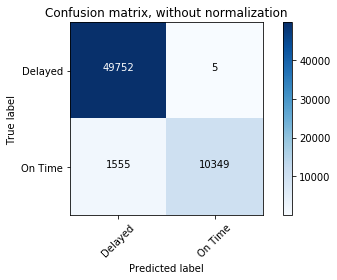

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('Delayed','On Time'),
                      title='Confusion matrix, without normalization')


### Random Forest

## Monkey Model (assume predict all on-time)

In [ ]:
# create training target assuming always on-time
no_delays = np.zeros(shape=y_test.shape, dtype='int')

In [ ]:
print(y_train.shape,no_delays.shape)

In [ ]:
print(accuracy_score(y_test,no_delays))
print(classification_report(y_test, no_delays))

### Confusion Matrix

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


### TRY

Split date in to YEAR, MONTH, DAY, DAYOFWEEK   

There's a datetime option that adds holidays     

plot_confusion_matrix   
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

LASSO for Logistic Regression   
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

grid search for optimal tuning parameters

pipeline

Look at modeling each month individually    

Look at mixing each year together